# Polytopes and uncertainty for synthetic multiclass dataset

Here we create some neat plots for a synthetic multiclass dataset and put uncertainty levels of a ReLU network and the linear decision regions (polytopes) it induces in the feature space due to its architecture. 

**Important**: For this to work, place in the ``/examples`` directory of the [Jordan et al. (2019)](https://arxiv.org/pdf/1903.08778.pdf) paper repo: https://github.com/revbucket/geometric-certificates.

Furthermore, the requirements for this can be installed using the ``requirements_plot.txt`` found in this repo. The model training part of is more or less adapted from their example notebook found [here](https://github.com/revbucket/geometric-certificates/blob/master/examples/2D_example.ipynb).

The data generation part was taken and modified from Pacmed's [repo for uncertainty estimation on electronic health records](https://github.com/Pacmed/ehr_ood_detection), more specifically this notebook [here](https://github.com/Pacmed/ehr_ood_detection/blob/master/notebooks/multiclass_uncertainty.ipynb).

In [1]:
import sys 
sys.path.append('.')
sys.path.append('..')

import random

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from geocert import GeoCert
from _polytope_ import Polytope
import polytope as ptope
from utilities import plot_polytopes_2d, Polytope_2
from plnn import PLNN

PLNN ../plnn.py


In [2]:
# Set seeds
SEED = 1234
np.random.seed(1234)
torch.manual_seed(1234)

# Define some constants here that stay fixed for the entire notebook
side_length = 10
XY_LIM = [-side_length/2, side_length/2]  # Limits of feature space, center around origin
FIGSIZE = (side_length, side_length)  # Plot size
DECISION_RADIUS = side_length/2  # Radius for Geocert to look for polytopes as l_inf distance
ORIGIN = torch.Tensor([0, 0])  # Origin of 2D space from which polytopes will be discovered


## Data generation

This block just generated 9 clusters of points following different multivariate normal distributions with diagonal covariances. The cluster locations are hardcoded.

In [3]:
# Generate data clusters 

def generate_cluster(mean, size, label):
    c = np.random.multivariate_normal(mean=mean, cov=np.diag(np.random.uniform(0.02, 0.1, size=(2,))), size=size)
    return c

cluster_locations = [
    np.array([0.5, -0.5]), np.array([0, -1.5]), np.array([-1.3,-1]), np.array([-1.5,0]), np.array([-0.1,0.5]),
    np.array([ -2.5, 0.5]), np.array([ 1.5, 0]), np.array([2, 1.1]), np.array([2, -1.5])
]
cluster_size = 50 
         
X = []
for label, cluster_mean in enumerate(cluster_locations):
    cluster_X = generate_cluster(cluster_mean, cluster_size, label)
    X.append(cluster_X)
    
X = np.concatenate(X, axis=0)
y = (np.ones((cluster_size, 9)) * np.arange(9)).T.reshape(cluster_size * 9)

In [4]:
# Generate meshgrid
step_size = .1 

xx, yy = np.meshgrid(np.arange(*XY_LIM, step_size), np.arange(*XY_LIM, step_size))
X_grid = np.c_[xx.ravel(), yy.ravel()]

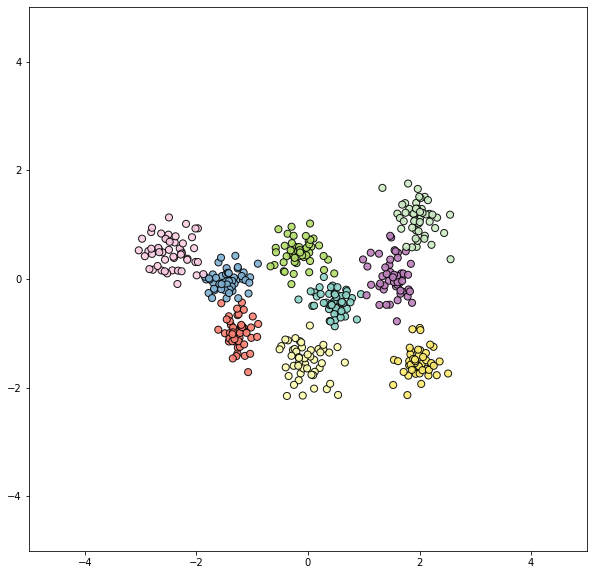

In [5]:
# Quick check on how the clusters are looking 

plt.figure(figsize=FIGSIZE)
axes = plt.gca()
axes.set_xlim(XY_LIM)
axes.set_ylim(XY_LIM)
plt.scatter(X[:, 0], X[:, 1],  c=y, cmap='Set3',
                edgecolors='k', alpha=0.9, s=50)

In [6]:
# Simplest dataset class to be compatible with torch DataLoader

class SimpleDataset(Dataset):

    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]

In [7]:
# Training block -- train a simple 2d Network 
# --- define network 
plnn_obj = PLNN(layer_sizes=[2, 5, 5, 9])
net = plnn_obj.net
X_torch, y_torch = torch.FloatTensor(X), torch.LongTensor(y)
data_loader = DataLoader(SimpleDataset(X_torch, y_torch), batch_size=8, shuffle=True)

# --- train network 
n_epochs = 100
opt = optim.Adam(net.parameters(), lr=0.001)
for _ in range(n_epochs):
    for i, (batch_X, batch_y) in enumerate(data_loader):
        out = net(Variable(batch_X))
        l = nn.CrossEntropyLoss()(out, Variable(batch_y))
        err = (out.max(1)[1].data !=  batch_y).float().mean()
        if i % 100 == 0:
            print(l.item(), err)
        opt.zero_grad()
        (l).backward()
        opt.step()
print(l.item())

[2, 5, 5, 9]
2.2597646713256836 tensor(0.8750)
2.233344554901123 tensor(0.6250)
2.0529162883758545 tensor(0.5000)
2.0607423782348633 tensor(0.6250)
2.0579333305358887 tensor(0.8750)
1.9373698234558105 tensor(0.7500)
1.6497693061828613 tensor(0.5000)
1.7861335277557373 tensor(0.6250)
1.1560540199279785 tensor(0.3750)
1.2644442319869995 tensor(0.3750)
1.3736776113510132 tensor(0.3750)
1.3994572162628174 tensor(0.3750)
1.2594563961029053 tensor(0.3750)
1.509743094444275 tensor(0.5000)
0.826307475566864 tensor(0.2500)
0.9309799671173096 tensor(0.2500)
1.113205909729004 tensor(0.3750)
0.8118152618408203 tensor(0.1250)
0.7854335308074951 tensor(0.1250)
0.8105298280715942 tensor(0.2500)
0.7354558706283569 tensor(0.)
0.791963517665863 tensor(0.)
0.889692485332489 tensor(0.3750)
0.5269873738288879 tensor(0.)
0.6218885183334351 tensor(0.1250)
0.5652172565460205 tensor(0.)
0.5802133083343506 tensor(0.1250)
0.7010998129844666 tensor(0.3750)
0.3808290958404541 tensor(0.2500)
0.5497368574142456 tens

## Defining plotting functions

Next, we define some plotting functions here. We want to produce the following plots: 

1. Plots of the uncertainty levels alongside data points (`plot_uncertainty()`)
2. Plot the polytopes (`plot_polytopes()`, adapted from [`plot_polytopes_2d()`](https://github.com/revbucket/geometric-certificates/blob/8730abaf2ab0c8972a2d40168d5fe64c8670fc62/utilities.py#L564) from original repo)
3. Plot polytopes overlayed on uncertainty levels and point (`plot_uncertainty_and_polytopes()`)

In [8]:
def plot_uncertainty(X, y, xx, yy, uncertainty, xy_lim, fig_size):
    plt.figure(figsize=fig_size)
    axes = plt.gca()
    axes.set_xlim(xy_lim)
    axes.set_ylim(xy_lim)
    cmap = plt.cm.Purples
    c = plt.contourf(
        xx, yy, uncertainty.reshape(xx.shape), cmap=cmap,
        levels=40
    )
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='Set1', 
                edgecolors='k', alpha=0.6, s=50)
    plt.axis('off')
    
def entropy(preds, dim):
    return -torch.sum(preds * torch.log2(preds+1e-8), dim=dim)

In [9]:
def plot_polytopes(polytopes, xy_lim, fig_size):
    plt.figure(figsize=fig_size)
    plt.xlim(*xy_lim)
    plt.ylim(*xy_lim)
    plt.xticks([])
    plt.yticks([])
    ax = plt.axes()
    
    cmap = matplotlib.cm.get_cmap('tab20c')
    colors = [cmap(random.random()) for _ in range(len(polytopes))]

    for poly, color in zip(polytopes, colors):
        P = Polytope_2(poly.ub_A, poly.ub_b)
        V = ptope.extreme(P)

        if V is not None:
            P.plot(ax, color=color, linestyle="-", alpha=0.6, linewidth=1)
        else:
            # Polytope may be unbounded, thus add additional constraints x in [-xylim, xylim]
            # and y in [-xylim, xylim]
            new_ub_A = np.vstack((poly.ub_A, [[1,0], [-1,0], [0,1], [0,-1]]))
            new_ub_b = np.hstack((poly.ub_b, [xy_lim[1], -1 * xy_lim[0], xy_lim[1], -1 * xy_lim[0]]))
            P2 = Polytope_2(new_ub_A, new_ub_b)
            V2 = ptope.extreme(P2)
            if V2 is not None:
                P2.plot(ax, color=color, linestyle="-", alpha=0.6, linewidth=1)

In [10]:
def _get_patch_custom(poly1, **kwargs):
    import matplotlib as mpl
    V = ptope.extreme(poly1)

    if (V is not None):
        rc, xc = ptope.cheby_ball(poly1)
        x = V[:, 1] - xc[1]
        y = V[:, 0] - xc[0]
        mult = np.sqrt(x**2 + y**2)
        x = x / mult
        angle = np.arccos(x)
        corr = np.ones(y.size) - 2 * (y < 0)
        angle = angle * corr
        ind = np.argsort(angle)
        # create patch
        patch = mpl.patches.Polygon(V[ind, :], True, **kwargs)
        # patch.set_zorder(0)  # This is annoying

    else:
        patch = mpl.patches.Polygon([], True, **kwargs)
        # patch.set_zorder(0)  # This is annoying
    return patch

# The original _get_patch() sets the order of layers with .set_zorder(0), which makes plotting the polytopes as 
# an overlay very difficult -> Thus just overwrite the function with a version that doesn't do this
import utilities
utilities._get_patch = _get_patch_custom


def _plot_scores_and_polytopes(X, y, xx, yy, scores, polytopes, xy_lim, fig_size, cmap):
    plt.figure(figsize=fig_size)
    plt.xlim(*xy_lim)
    plt.ylim(*xy_lim)
    plt.xticks([])
    plt.yticks([])
    ax = plt.axes()
    
    # Plot polytopes
    for poly in polytopes:
        P = Polytope_2(poly.ub_A, poly.ub_b)
        V = ptope.extreme(P)

        if V is not None:
            P.plot(ax, color="white", alpha=0.4, linewidth=2, linestyle="-")
        else:
            # Polytope may be unbounded, thus add additional constraints x in [-xylim, xylim]
            # and y in [-xylim, xylim]
            new_ub_A = np.vstack((poly.ub_A, [[1,0], [-1,0], [0,1], [0,-1]]))
            new_ub_b = np.hstack((poly.ub_b, [xy_lim[1], -1 * xy_lim[0], xy_lim[1], -1 * xy_lim[0]]))
            P2 = Polytope_2(new_ub_A, new_ub_b)
            V2 = ptope.extreme(P2)
            if V2 is not None:
                P2.plot(ax, color="white", alpha=0.4, linewidth=2, linestyle="-")  
                
     # Plot uncertainty 
    ax.contourf(
        xx, yy, scores.reshape(xx.shape), cmap=cmap, levels=40, alpha=1
    )  
                
    # Plot points
    ax.scatter(X[:, 0], X[:, 1], c=y,cmap='Set1', edgecolors='k', alpha=1, s=50)
    plt.show()

def plot_uncertainty_and_polytopes(X, y, xx, yy, uncertainty, polytopes, xy_lim, fig_size):
    _plot_scores_and_polytopes(X, y, xx, yy, uncertainty, polytopes, xy_lim, fig_size, cmap=plt.cm.Purples)
    
def plot_grad_magnitude_and_polytopes(X, y, xx, yy, grad_magnitudes, polytopes, xy_lim, fig_size):
    _plot_scores_and_polytopes(X, y, xx, yy, grad_magnitudes, polytopes, xy_lim, fig_size, cmap=plt.cm.YlGn)
    
def plot_change_grad_magnitude_and_polytopes(X, y, xx, yy, change_grad_magnitudes, polytopes, xy_lim, fig_size):
    _plot_scores_and_polytopes(X, y, xx, yy, change_grad_magnitudes, polytopes, xy_lim, fig_size, cmap=plt.cm.Reds)

## Actually plot everything 

Now we plot everything by just getting uncertainty scores for the whole feature space and then running `GeoCert` to discover the polytopes based on the trained model and then plotting them using the other functions defined in the previous section.

In [11]:
import torch.autograd as autograd

X_grid_torch = torch.FloatTensor(X_grid)
X_grid_torch.requires_grad = True
preds = torch.softmax(net(X_grid_torch), dim=1)
uncertainty = entropy(preds, dim=1)
first_derivative, = autograd.grad(
    uncertainty, X_grid_torch, grad_outputs=torch.ones(uncertainty.shape), create_graph=True
)
grad_magnitude = torch.norm(first_derivative, dim=1)

change_grad_magnitude, = autograd.grad(grad_magnitude, X_grid_torch, grad_outputs=torch.ones(grad_magnitude.shape))
change_grad_magnitude = torch.norm(change_grad_magnitude, dim=1)

# Detach and convert to numpy
uncertainty = uncertainty.detach().numpy()
grad_magnitude = grad_magnitude.detach().numpy()
change_grad_magnitude = change_grad_magnitude.detach().numpy()

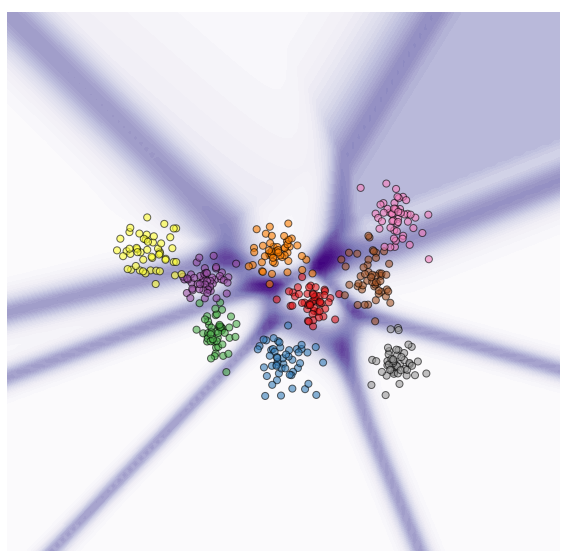

In [12]:
plot_uncertainty(X, y, xx, yy, uncertainty, XY_LIM, FIGSIZE)

In [13]:
# Retrieve polytopes
geo = GeoCert(plnn_obj, hyperbox_bounds=XY_LIM, verbose=True, neuron_bounds="full_lp")

region_count = geo.run(
    ORIGIN, lp_norm='l_inf', problem_type='count_regions', decision_radius=DECISION_RADIUS
)
polytopes = []

for polytope in region_count.seen_polytopes:
    config = plnn_obj.config_str_to_config_list(polytope)
    polytope_config = plnn_obj.compute_polytope_config(config)
    poly = Polytope.from_polytope_dict(polytope_config, ORIGIN)
    polytopes.append(poly)

Restricted license - for non-production use only - expires 2022-01-13
---Initial Polytope---
(p0) Popped: 0.000208  | 5.000000
(p0) Popped: 0.252828  | 5.000000
(p0) Popped: 0.301096  | 5.000000
(p0) Popped: 0.340204  | 5.000000
(p0) Popped: 0.384130  | 5.000000
(p0) Popped: 0.429908  | 5.000000
(p0) Popped: 0.445789  | 5.000000
(p0) Popped: 0.451633  | 5.000000
(p0) Popped: 0.574307  | 5.000000
(p0) Popped: 0.585497  | 5.000000
(p0) Popped: 0.615437  | 5.000000
(p0) Popped: 0.653730  | 5.000000
(p0) Popped: 0.907959  | 5.000000
(p0) Popped: 1.008844  | 5.000000
(p0) Popped: 1.051473  | 5.000000
(p0) Popped: 1.051473  | 5.000000
(p0) Popped: 1.108656  | 5.000000
(p0) Popped: 1.274628  | 5.000000
(p0) Popped: 1.304021  | 5.000000
(p0) Popped: 1.334885  | 5.000000
(p0) Popped: 1.340823  | 5.000000
(p0) Popped: 1.380451  | 5.000000
(p0) Popped: 1.439800  | 5.000000
(p0) Popped: 1.464972  | 5.000000
(p0) Popped: 1.509923  | 5.000000
(p0) Popped: 1.526551  | 5.000000
(p0) Popped: 1.529260  

../domains.py:365: RuntimeWarning: divide by zero encountered in true_divide
  under_upper_bound = np.divide(b - A.dot(self.x), duals) <= upper_bound


/Users/deul/anaconda3/envs/geocert/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


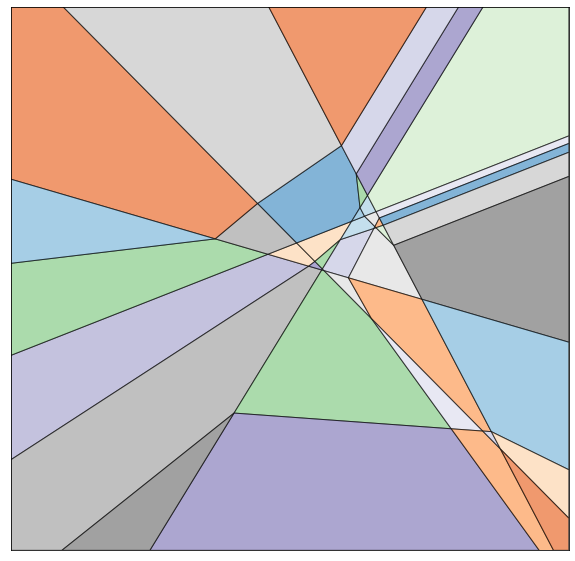

In [14]:
plot_polytopes(polytopes, XY_LIM, FIGSIZE)

/Users/deul/anaconda3/envs/geocert/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


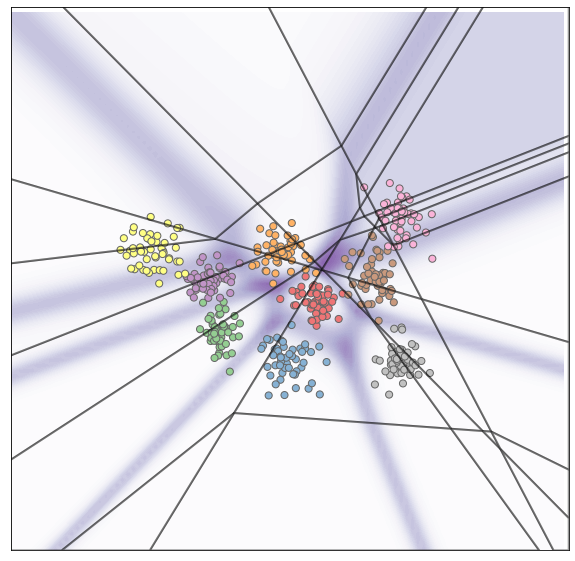

In [15]:
plot_uncertainty_and_polytopes(X, y, xx, yy, uncertainty, polytopes, XY_LIM, FIGSIZE)

/Users/deul/anaconda3/envs/geocert/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


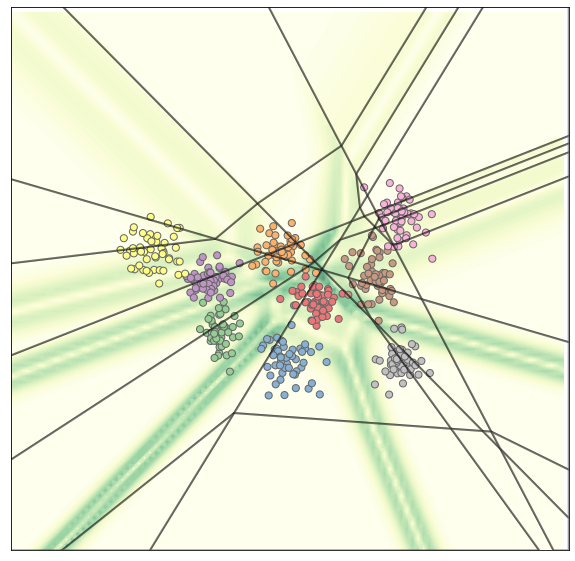

In [16]:
plot_grad_magnitude_and_polytopes(X, y, xx, yy, grad_magnitude, polytopes, XY_LIM, FIGSIZE)

/Users/deul/anaconda3/envs/geocert/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


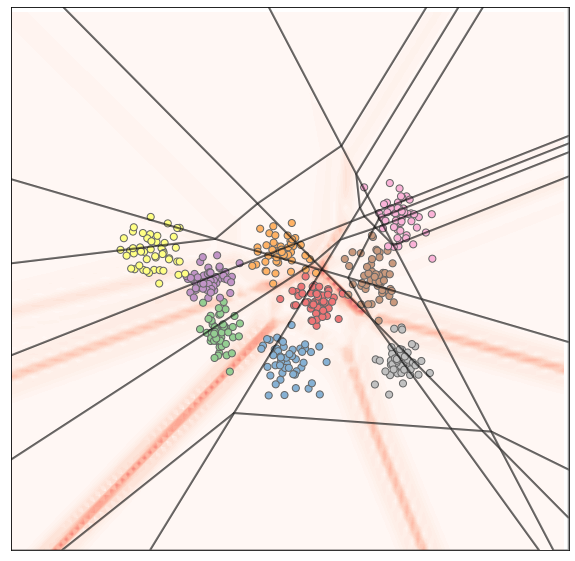

In [17]:
plot_change_grad_magnitude_and_polytopes(X, y, xx, yy, change_grad_magnitude, polytopes, XY_LIM, FIGSIZE)